### Read in Data

1. Dataset Overview
audio_features: Shows individual arrays of numerical features as strings. This is expected at this stage, as you haven’t yet converted these to actual numerical arrays.
model_type: All rows belong to one type (A). This may suggest a lack of diversity in the model_type column, which might not be useful for classification if it doesn’t vary.
maneuvering_direction: Contains six unique values (e.g., R, CC, C), representing directions such as Right, Counter-Clockwise, and so on.
fault: Contains nine unique values (e.g., PC3, MF3).
2. Column Statistics
Count: Every column has 64,800 non-null entries, so there are no missing values. This is great for training machine learning models.
Unique:
audio_features: 64,800 unique rows, meaning no duplicate audio feature data.
model_type: Only one unique value (A), which makes it unsuitable for classification. You may need to ignore this column unless your dataset changes.
maneuvering_direction and fault: These have a manageable number of unique categories for classification tasks.
Top/Freq:
Indicates the most common values (top) and their frequencies (freq). For instance:
maneuvering_direction → R is the most frequent with 10,800 entries.
fault → PC3 is the most frequent with 7,200 entries.

In [63]:
import pandas as pd

# Replace with the actual path to your downloaded file
data = pd.read_csv("Data.csv")

# View the first few rows
print(data.head())
print(data.describe())  # Summary statistics
print(data['model_type'].value_counts())  # Unique values for drone models
print(data.isnull().sum())

                                      audio_features model_type  \
0  [-60.44415   116.25432   -46.292316   65.45784...          A   
1  [-58.29744   107.7279    -46.689884   59.33999...          A   
2  [-60.845535   116.55775    -44.339348    69.30...          A   
3  [-74.25324   109.67719   -34.924404   71.4471 ...          A   
4  [-76.636406   113.815056   -41.341892    68.81...          A   

  maneuvering_direction fault  
0                     R   PC3  
1                     R   MF3  
2                    CC   MF1  
3                     C   MF4  
4                     F   MF2  
                                           audio_features model_type  \
count                                               64800      64800   
unique                                              64800          1   
top     [-56.820847   118.1124     -46.04536     74.49...          A   
freq                                                    1      64800   

       maneuvering_direction  fault  
count 

### Convert the audio column and extract features and labels
Explanation of the Output
Feature Matrix (X):

Shape: (64800, 40)
64800: The number of samples (rows) in your dataset.
40: The number of features (columns) in each audio_features array. This is consistent with your dataset's structure, where each sample's audio features are represented as a 40-dimensional array.
Model Labels (y_model):

Shape: (64800,)
This is a 1D array with one label for each of the 64,800 samples, corresponding to the drone's model_type.
Maneuvering Labels (y_maneuver):

Shape: (64800,)
Similarly, this is a 1D array with one label per sample, describing the maneuvering_direction (e.g., R, CC, C).
Fault Labels (y_fault):

Shape: (64800,)
This 1D array contains the fault types for each sample (e.g., PC3, MF3).

In [64]:
import numpy as np
# This method converts the audio column into a useable array
def parse_audio_features(feature_string):
    #Strips brackets and converts string to array
    return np.fromstring(feature_string.strip('[]'), sep=' ')

# Apply the function to all rows in the audio_features column
data['audio_features'] = data['audio_features'].apply(parse_audio_features)

# Separate features (X) and labels (y) for different classification tasks
# Extract the audio features into a feature matrix (X)
X = np.stack(data['audio_features'].values)

# Extract labels for classification tasks
y_model = data['model_type']                # Drone model classification
y_maneuver = data['maneuvering_direction']  # Maneuvering direction classification
y_fault = data['fault']                     # Fault detection classification

# Print the shapes of the feature matrix and label arrays for verification
print("Feature Matrix (X):", X.shape)
print("Model Labels (y_model):", y_model.shape)
print("Maneuvering Labels (y_maneuver):", y_maneuver.shape)
print("Fault Labels (y_fault):", y_fault.shape)

Feature Matrix (X): (64800, 40)
Model Labels (y_model): (64800,)
Maneuvering Labels (y_maneuver): (64800,)
Fault Labels (y_fault): (64800,)


### Data Splitting
The 80/20 split is a commonly used ratio in machine learning for dividing a dataset into training and testing subsets. With 20% testing data, you generally have enough samples to reliably measure metrics like accuracy, precision, recall, and F1-score.

In [65]:
from sklearn.model_selection import train_test_split

# Split the feature matrix (X) and each label (y) into training and testing sets

# For model_type classification
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    X, y_model, test_size=0.2, random_state=42
)

# For maneuvering_direction classification
X_train_maneuver, X_test_maneuver, y_train_maneuver, y_test_maneuver = train_test_split(
    X, y_maneuver, test_size=0.2, random_state=42
)

# For fault classification
X_train_fault, X_test_fault, y_train_fault, y_test_fault = train_test_split(
    X, y_fault, test_size=0.2, random_state=42
)

# Verify the shapes of the splits
print("Model Type Training Data:", X_train_model.shape, y_train_model.shape)
print("Model Type Testing Data:", X_test_model.shape, y_test_model.shape)

print("Maneuvering Training Data:", X_train_maneuver.shape, y_train_maneuver.shape)
print("Maneuvering Testing Data:", X_test_maneuver.shape, y_test_maneuver.shape)

print("Fault Training Data:", X_train_fault.shape, y_train_fault.shape)
print("Fault Testing Data:", X_test_fault.shape, y_test_fault.shape)

Model Type Training Data: (51840, 40) (51840,)
Model Type Testing Data: (12960, 40) (12960,)
Maneuvering Training Data: (51840, 40) (51840,)
Maneuvering Testing Data: (12960, 40) (12960,)
Fault Training Data: (51840, 40) (51840,)
Fault Testing Data: (12960, 40) (12960,)


### CNN Model Creation

Class Weights: {0: np.float64(1.0)}
Epoch 1/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9958 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 5.1331e-22
Epoch 2/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 3.5827e-11 - val_accuracy: 1.0000 - val_loss: 4.7393e-22
Epoch 3/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 5.5917e-12 - val_accuracy: 1.0000 - val_loss: 4.6373e-22
Epoch 4/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 1.4849e-12 - val_accuracy: 1.0000 - val_loss: 4.5924e-22
Epoch 5/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 6.7618e-12 - val_accuracy: 1.0000 - val_loss: 3.8472e-22
Epoch 6/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 3.3096e-12 - val_accuracy: 1.0000 - val_loss: 3.7273e-22
Epoch 7/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 4.9405e-12 - val_accuracy: 1.0000 - val_loss: 3.4769e-22
Ep

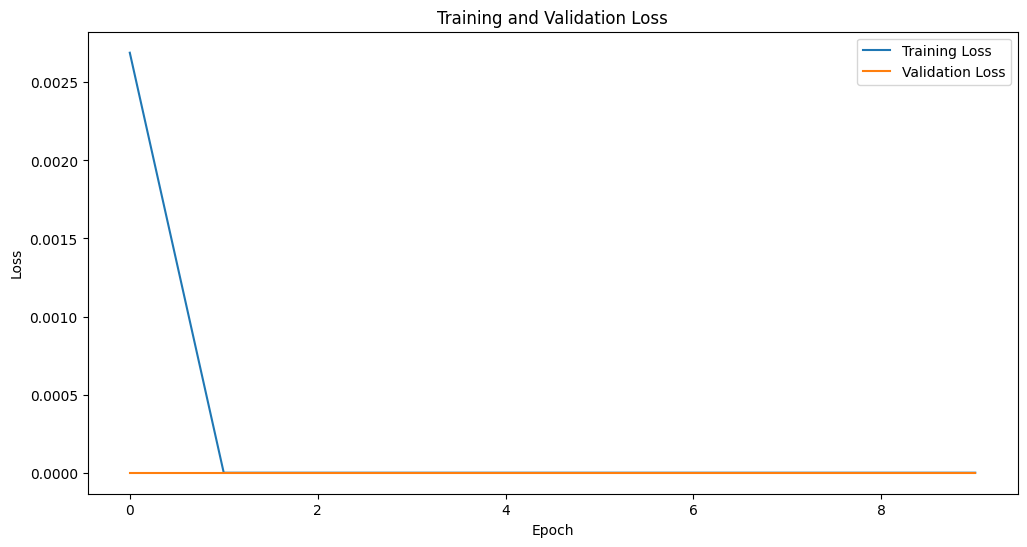

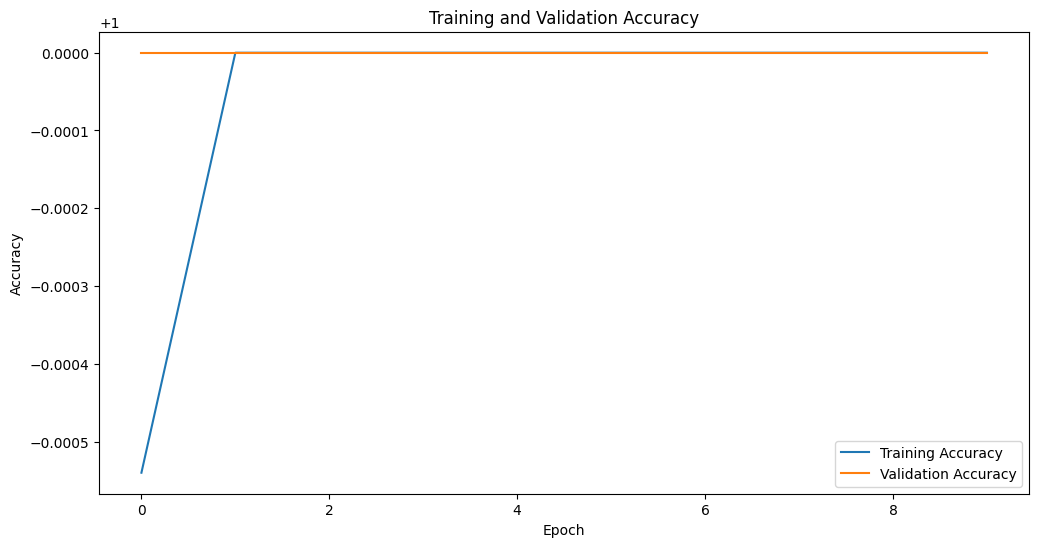

X_train_cnn shape: (51840, 40, 1)
X_test_cnn shape: (12960, 40, 1)
Model Input shape: (None, 40, 1)


In [66]:
# Import necessary libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

y = y_model.values
# --- Step 1: Stratified Splitting ---
# Ensure balanced splitting of dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2: Preprocess Labels ---
# Encode labels to integers (if categorical)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# --- Step 3: Compute Class Weights ---
# Handle class imbalance by computing weights for each class
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

# --- Step 4: Reshape Input Data ---
# Add a channel dimension to the input data (needed for Conv1D)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# --- Step 5: Build the CNN Model ---
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_cnn.shape[1], 1)),  # Explicit input layer
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# --- Step 6: Train the Model ---
history = cnn_model.fit(
    X_train_model, y_train_encoded,
    validation_data=(X_test_cnn, y_test_encoded),
    epochs=10,
    batch_size=32
)

# --- Step 7: Evaluate the Model ---
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_encoded)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# --- Step 8: Save the Model ---
cnn_model.save('cnn_model.keras')  # New recommended format


# --- Step 9: Visualize Training Progress ---
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)
print("Model Input shape:", cnn_model.input_shape)

In [67]:
#TODO: fix confusion matrix for columns that have all the same value
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
y_pred = cnn_model.predict(X_test_cnn)
y_pred_binary = (y_pred > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_binary, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_binary)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Unique classes in y_test_encoded: [0]
Class distribution in y_test_encoded: [12960]
Unique predictions: [0]
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     12960

    accuracy                           1.00     12960
   macro avg       1.00      1.00      1.00     12960
weighted avg       1.00      1.00      1.00     12960


TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# 
# def audio_to_mel_spectrogram(audio_features, sample_rate=22050, target_rate=8000, n_mels=32, save_image=False, image_name="mel_spectrogram.png"):
#     """
#     Convert an audio signal to a Mel-spectrogram with adjustments for short signals, stretching, and resampling.
#     
#     Parameters:
#         audio_features (list or np.ndarray): The audio features (raw audio data).
#         sample_rate (int): Original sampling rate of the audio signal.
#         target_rate (int): Target sampling rate after resampling.
#         n_mels (int): Number of Mel bands to generate.
#         save_image (bool): Whether to save the spectrogram as an image.
#         image_name (str): Name of the image file to save.
# 
#     Returns:
#         np.ndarray: The computed Mel-spectrogram.
#     """
#     # Convert to numpy array if audio features are not already in that format
#     audio = np.array(audio_features, dtype=np.float32)
#     
#     # Normalize the audio
#     audio = librosa.util.normalize(audio)
#     
#     # Stretch the audio to artificially lengthen it
#     audio = librosa.effects.time_stretch(audio, rate=0.5)  # Stretch to 50% speed
#     
#     # Resample audio to target sampling rate
#     audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_rate)
#     
#     # Pad audio to ensure enough samples
#     audio = pad_audio(audio, target_length=8192)  # Pad to 8192 samples
#     print("Stretched, resampled, and padded audio length:", len(audio))  # Debug
# 
#     # Compute Mel-spectrogram
#     n_fft = 1024
#     hop_length = n_fft // 8
#     mel_spectrogram = librosa.feature.melspectrogram(
#         y=audio, sr=target_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
#     )
#     
#     # Convert to log scale for better visualization
#     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
#     
#     if save_image:
#         # Plot and save the Mel-spectrogram as an image
#         plt.figure(figsize=(10, 4))
#         librosa.display.specshow(mel_spectrogram_db, sr=target_rate, x_axis='time', y_axis='mel', cmap='viridis')
#         plt.colorbar(format='%+2.0f dB')
#         plt.title("Mel-Spectrogram")
#         plt.tight_layout()
#         plt.savefig(image_name)
#         plt.close()
#     
#     return mel_spectrogram_db
# 
# 
# 
# 
# def pad_audio(audio, target_length=2048):
#     """
#     Pads or truncates the audio signal to the target length.
#     """
#     if len(audio) < target_length:
#         pad_width = target_length - len(audio)
#         return np.pad(audio, (0, pad_width), mode='constant')
#     else:
#         return audio[:target_length]
# 
# 
# # Example: Convert an entire dataset's audio features into Mel-spectrograms
# # Replace `data['audio_features']` with your actual dataset column containing audio data
# mel_spectrograms = []
# for idx, audio in enumerate(data['audio_features']):
#     mel_spec = audio_to_mel_spectrogram(audio, sample_rate=22050, n_mels=128, save_image=False)
#     mel_spectrograms.append(mel_spec)
# 
# # Convert to a NumPy array for further processing
# mel_spectrograms = np.array(mel_spectrograms)
# 
# # Standardize the length of Mel-spectrograms
# mel_spectrograms_padded = pad_sequences(mel_spectrograms, padding="post", dtype="float32")
# 
# # Print shapes for verification
# print("Original Mel-spectrograms shape:", mel_spectrograms.shape)
# print("Padded Mel-spectrograms shape:", mel_spectrograms_padded.shape)
# 
# #print("Audio length after resampling and padding:", len(audio))
# 
# plt.figure(figsize=(10, 4))
# plt.plot(audio)
# plt.title("Resampled and Padded Audio Signal")
# plt.xlabel("Sample Index")
# plt.ylabel("Amplitude")
# plt.show()
# 
# 
# # Example: Visualize the first Mel-spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrograms[0], sr=22050, x_axis="time", y_axis="mel", cmap="viridis")
# plt.colorbar(format="%+2.0f dB")
# plt.title("Mel-Spectrogram Example")
# plt.show()
